# Notebook 8: Rework of Notebook 5 

## This notebook geocodes the addresses for buildings
Plan for this mapping project is ideally to: 

1. Create a dataframe that has the lat/lng based on postal code/address
2. Select the dataframe corresponding to a year
3. Rename the columns to standardised values
4. Drop duplicates based on building_id
5. Get the building name, lat/lng and energy star score for each building_id (from the preprocessing dataframe if necessary)
6. Plot


In [1]:
#import necesary things for this project: 
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import json
import folium
import plotly.express as px
import plotly
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Set up of master data frame that combines all 5 years of data

## Part 1: Clean-up and merge
Step 1: get a list of csv files in the data folder: only want the ones that end in _201*.csv
e.g.
      ```
        energy_usage_large_commercial_buildings_reported_2013.csv
        properties_reported_2015.csv
        ..etc..
      ```

In [2]:
data_files = [f for f in os.listdir('../data') if re.search('_201[3-7].csv',f)]


Step 2: Write a code that maps the columns names I am interested in plotting on the map since not all years have the same column names, e.g.
* Building ID is named OPA account number for 2015-2017
* Street address isn't uniform 

In [3]:
column_mapping = {
    'philadelphia_building_id': 'building_id',
    'opa_account_num': 'building_id',
    'location_1_address': 'street_address'
}

Step 3: Clean Data Frame
* Drop the duplicate building id's 
* Drop any building ids that are not numbers by using pd.to_numeric and coerce to change any building id that is not a number into NA so that we can drop those too (this allows me to drop anything that is not unique and a number without having to specify every error)

In [4]:
def clean_dataframe(df):
    uniques = df.drop_duplicates(subset=['building_id'])
    return uniques.assign(building_id=pd.to_numeric(uniques['building_id'], errors='coerce')).dropna(subset=['building_id'])



Step 4: Make a new df "rawdf" that takes the data_files we want from the parent directory (pardir) and renames the according columns in my mapping, then add a column to the end that assigns each row a year number based on the dataframe that it is in to be able to keep track of years for possible "over time" analysis.

I also need to fix the column 'street_address'. That is, some of the values have hyphens and for my lookup code that makes an error. Thus if I change it in the beginning then I can get the lat and long of far more buildings.

In [5]:
raw_dfs = [pd.read_csv(os.path.join(os.pardir, 'data', filename)).rename(columns=column_mapping).assign(year=year) for year, filename in enumerate(sorted(data_files), 2013)]
dfs = [clean_dataframe(raw_df) for raw_df in raw_dfs]


In [6]:
#created a function 'fix_addr' that fixes the column street attress 
def fix_addr(row, address_col='street_address'):
    row[address_col] = re.sub('^(\d+)-\d+','\\1', row[address_col]) 
#make the function return the same thing but editted without the hyphen    
    return row

#set up for loop for all my dataframes that applies the function to the street address 
for i, df in enumerate(raw_dfs):
    if 'street_address' in df:
        raw_dfs[i] = raw_dfs[i].apply(fix_addr, axis=1)
#I need a if and ifelse because 2014 column name for address is location_1_address and not street_address
    elif 'location_1_address' in df:
        raw_dfs[i] = raw_dfs[i].apply(lambda x: fix_addr(x, 
                                                         'location_1_address'), axis=1)


Step 5: Merge all the dataframe with concat into a final dataframe called 'df'

In [7]:
df = pd.concat(raw_dfs)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




# Get the necessary information per column to be able to map
* yr2013_df already has the long and lat 
* 2014-2018 give street addresses and postal codes that I will put through a geo-lookup finder to get the long and lat 

In [8]:
#get the building ids that have lat and long
gb = df.groupby('building_id')[['lat', 'lng']].mean()

#get the building ids that dont have lat or lng
geocoding_ids = gb[gb.isna().any(axis=1)].index

In [39]:
#this is the dataframe for the buildings that don't have lng and lat that we need to look up 
geocoding_df = df.loc[df['building_id'].isin(geocoding_ids), ['building_id', 'street_address', 'postal_code','energy_star_score', 'property_name']]

Save this geo_coding_df into a csv that I can run through the lookup in parts

In [40]:
geocoding_df.to_csv('../data/buildings_needing_geoinfo.csv', index=False)

# Long and Lat Look-up

In [42]:
geolocator = Nominatim(user_agent='application')
lookup = RateLimiter(geolocator.geocode, min_delay_seconds=1)

results = []

#create a code that allows the look-up to run more smoothly with try and except for the errors


for building_id, street, zip_code in geocoding_df[['building_id', 'street_address', 'postal_code']].values:
    try:
        zip_code = f'{zip_code:.0f}'
    except:
        pass
    address = f'{street.title()}, PA {zip_code}'
    location = lookup(address, language='en', exactly_one=True)
    if location is not None:
        results.append([building_id, location.latitude, location.longitude])
    
    
    else:
        print(f'Could not find lat/long for address {address}')


Could not find lat/long for address 1301 C.B. Moore, PA 19122
Could not find lat/long for address 2045 Wheatsheef Lain, PA 19134
Could not find lat/long for address 2136 Onterio Street Pump, PA 19134
Could not find lat/long for address Rock, Park Ave, Parkinson, PA 19140
Could not find lat/long for address 4300 Westminister Ave, PA 19104
Could not find lat/long for address 1034 South 6Oth St, PA 19143
Could not find lat/long for address 22Nd & Ritner St, PA 19145
Could not find lat/long for address 834 Chestnut Street, Philadelphia, Pa 19107, PA 19107
Could not find lat/long for address Marine Center - Pier #19, PA 19106
Could not find lat/long for address 22 East Chestnuthill Avenue, PA 19118
Could not find lat/long for address 2020 N. 13Th, PA 19122
Could not find lat/long for address 101 N Independence Mall E, PA 19106
Could not find lat/long for address 111 South11Th St, PA 19107
Could not find lat/long for address 100 S Independence Mall W, PA 19106
Could not find lat/long for add

RateLimiter caught an error, retrying (0/2 tries). Called with (*('2514 Emerald St, PA 19125',), **{'language': 'en', 'exactly_one': True}).
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 1320, in do_open
    r = h.getresponse()
  File "/usr/local/anaconda3/lib/python3.7/http/client.py", line 132

Could not find lat/long for address 259 Market St # 2, PA 19106
Could not find lat/long for address 9300 Ashton Rdunit 1, PA 19114


RateLimiter caught an error, retrying (0/2 tries). Called with (*('4250 Main St, PA 19127',), **{'language': 'en', 'exactly_one': True}).
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 1320, in do_open
    r = h.getresponse()
  File "/usr/local/anaconda3/lib/python3.7/http/client.py", line 1321, 

Could not find lat/long for address 800 Walnut St Unit A5, PA 19103
Could not find lat/long for address 3711L Market St, PA 19104
Could not find lat/long for address 2025L Benjamin Franklin Pkwy, PA 19130
Could not find lat/long for address 1115 Polett Walk, PA 19122
Could not find lat/long for address 1210 W Godfrey Ave, PA 19141
Could not find lat/long for address 7701R Burholme Ave, PA 19111
Could not find lat/long for address 13500 E Roosevelt Blvd, PA 19116
Could not find lat/long for address 11500 E Roosevelt Blvd, PA 19116
Could not find lat/long for address 4641 E Roosevelt Blvd, PA 19124
Could not find lat/long for address 1700 Ritner St, PA 19145
Could not find lat/long for address 1 Citizens Bank Way, PA 19148
Could not find lat/long for address 11500 E Roosevelt Blvd, PA 19116
Could not find lat/long for address 11681 E Roosevelt Blvd, PA 19154
Could not find lat/long for address 7133R E Roosevelt Blvd, PA 19149
Could not find lat/long for address 8401 E Roosevelt Blvd, PA 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('626 Dickinson St, PA 19147',), **{'language': 'en', 'exactly_one': True}).
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/usr/local/anaconda3/lib/python3.7/http/client.py", line 1229, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/local/anaconda3/lib/python3.7/http/client.py", line 1275, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/local/anaconda3/lib/python3.7/http/client.py", line 1224, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/local/anaconda3/lib/python3.7/http/client.py", line 1016, in _send_output
    self.send(msg)
  File "/usr/local/anaconda3/lib/python3.7/http/client.py", line 956, in send
    self.connect()
  File "/usr/local/anaconda3/lib/

Could not find lat/long for address 11771 E Roosevelt Blvd, PA 19154
Could not find lat/long for address 9501 E Roosevelt Blvd, PA 19114
Could not find lat/long for address 920 W Spencer Ave, PA 19141
Could not find lat/long for address 6025 E Roosevelt Blvd, PA 19149
Could not find lat/long for address 7101 E Roosevelt Blvd, PA 19149
Could not find lat/long for address 2136 Ritner St, PA 19145
Could not find lat/long for address 11451 E Roosevelt Blvd, PA 19154
Could not find lat/long for address 170 S Independence Mall W, PA 19106
Could not find lat/long for address 11000 E Roosevelt Blvd, PA 19116
Could not find lat/long for address 30Th & Walnut St, PA 19104
Could not find lat/long for address 9745R E Roosevelt Blvd, PA 19114
Could not find lat/long for address 4660 E Roosevelt Blvd, PA 19124
Could not find lat/long for address 1503A-11 Arch St, PA 19102
Could not find lat/long for address 9725R E Roosevelt Blvd, PA 19114
Could not find lat/long for address 3200L Chestnut St # A, P

RateLimiter caught an error, retrying (0/2 tries). Called with (*('4250 Main St, PA 19127',), **{'language': 'en', 'exactly_one': True}).
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.7/site-packages/geopy/geocoders/base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/usr/local/anaconda3/lib/python3.7/urllib/request.py", line 1320, in do_open
    r = h.getresponse()
  File "/usr/local/anaconda3/lib/python3.7/http/client.py", line 1321, 

Could not find lat/long for address 800 Walnut St Unit A5, PA 19103
Could not find lat/long for address 9300 Ashton Rdunit 1, PA 19114
Could not find lat/long for address 2025L Benjamin Franklin Pkwy, PA 19130
Could not find lat/long for address 1115 Polett Walk, PA 19122
Could not find lat/long for address 1114 Polett Walk, PA 19122
Could not find lat/long for address 7701R Burholme Ave, PA 19111
Could not find lat/long for address 7133R E Roosevelt Blvd, PA 19149
Could not find lat/long for address 5400 Eadom St, PA 191371303
Could not find lat/long for address 11500 E Roosevelt Blvd, PA 19116
Could not find lat/long for address 1700 Ritner St, PA 19145
Could not find lat/long for address 11500 E Roosevelt Blvd, PA 19116
Could not find lat/long for address 7600 E Roosevelt Blvd, PA 19152
Could not find lat/long for address 8900 E Roosevelt Blvd, PA 19115
Could not find lat/long for address 8301 E Roosevelt Blvd, PA 19152
Could not find lat/long for address 9173 E Roosevelt Blvd, PA 1

In [50]:
result_df = pd.DataFrame(results, columns=['building_id', 'lat', 'lng'])


In [44]:
#make sure it worked
result_df.sample(30)

,building_id,lat,lng
3524,883308700,39.952129,-75.158546
3827,775515000,40.060502,-75.191447
65,7.84061e+08,40.053701,-75.178044
431,883745200,39.890811,-75.243950
2020,884080300,39.977833,-75.138978
4151,788008800,39.888642,-75.180375
2718,774502000,39.995663,-75.238120
3956,776506000,40.038594,-75.158272
69,7.86034e+08,40.020723,-75.059387
530,786066200,40.072512,-75.046643


Create a new csv so that you don't have to run the entire lookup again

In [45]:
result_df.to_csv('../data/totaldf_lat_long.csv', index=False)

# Attempt to clean up dataframe for mapping
### (I tried to add the lookup back into the giant master dataframe but could not) the next chunk shows my attempt)

Now create a dataframe that combines "df" and "results df" by indexing the 2 according to building_id. I am going to indicate what columns and information I want to keep. I want the following metrics in my final map:
* building_id
* address 
* energy STAR score
* long and lat
* property name

This will allow people to click on a building and see its energy STAR score (the best metric available in the data for overall energy efficiency)

In [52]:
#how many buildings do we have the location of?
print(len(result_df))
#4198 buildings

4198


In [53]:
result_df.set_index('building_id')

,lat,lng
building_id,,
785548000.0,40.040870,-75.128697
884240500.0,40.107684,-75.020026
784378000.0,40.031639,-75.213286
783183400.0,39.941010,-75.215312
771637200.0,39.782717,-75.977673
775501010.0,40.020047,-75.192867
774517051.0,39.953800,-75.188500
882065510.0,40.046206,-75.056565
884292580.0,40.109144,-74.979857


In [70]:
#add empty lat and lng columns
import numpy as np
geocoding_df['lat'] = np.nan

In [71]:
geocoding_df['lng'] =np.nan

In [72]:
geocoding_df.head()

,building_id,street_address,postal_code,energy_star_score,property_name,lat,long,lng
0,7.85548e+08,450 W NEDRO AVE,19120,11,Lowell,NaN,NaN,NaN
1,8.84240e+08,10814 NE AVENUE,19116,Not Available,10814 NE AVENUE,NaN,NaN,NaN
4,7.84378e+08,6000 RIDGE AVE,19128,54,Levering,NaN,NaN,NaN
5,7.83183e+08,5001 GREENWAY AVE,19143,4,Comegys,NaN,NaN,NaN
12,7.71637e+08,401 South Broad Street,19147,Not Available,Gershman Hall,NaN,NaN,NaN


In [73]:
def clean_dataframe(geocoding_df):
    uniques = geocoding_df.drop_duplicates(subset=['building_id'])
    return uniques.assign(building_id=pd.to_numeric(uniques['building_id'], errors='coerce')).dropna(subset=['building_id'])

In [74]:
clean_dataframe(geocoding_df)

,building_id,street_address,postal_code,energy_star_score,property_name,lat,long,lng
0,785548000.0,450 W NEDRO AVE,19120,11,Lowell,NaN,NaN,NaN
1,884240500.0,10814 NE AVENUE,19116,Not Available,10814 NE AVENUE,NaN,NaN,NaN
4,784378000.0,6000 RIDGE AVE,19128,54,Levering,NaN,NaN,NaN
5,783183400.0,5001 GREENWAY AVE,19143,4,Comegys,NaN,NaN,NaN
12,771637200.0,401 South Broad Street,19147,Not Available,Gershman Hall,NaN,NaN,NaN
13,775501010.0,4201 Henry Ave,19144,Not Available,Philadelphia University,NaN,NaN,NaN
15,774517051.0,3200 Chestnut Street,19104,Not Available,8-Creese,NaN,NaN,NaN
21,882065510.0,2327 Cottman Ave,19149,96,Roosevelt Mall-Macy's Building,NaN,NaN,NaN
26,777570000.0,1301 C.B. MOORE,19122,Not Available,RITTER HALL,NaN,NaN,NaN
40,884203500.0,2045 Wheatsheef Lain,19134,84,2045 Wheatsheef Lain,NaN,NaN,NaN


In [81]:
clean_dataframe(geocoding_df.drop(columns ='long'))

,building_id,street_address,postal_code,energy_star_score,property_name,lat,lng
0,785548000.0,450 W NEDRO AVE,19120,11,Lowell,NaN,NaN
1,884240500.0,10814 NE AVENUE,19116,Not Available,10814 NE AVENUE,NaN,NaN
4,784378000.0,6000 RIDGE AVE,19128,54,Levering,NaN,NaN
5,783183400.0,5001 GREENWAY AVE,19143,4,Comegys,NaN,NaN
12,771637200.0,401 South Broad Street,19147,Not Available,Gershman Hall,NaN,NaN
13,775501010.0,4201 Henry Ave,19144,Not Available,Philadelphia University,NaN,NaN
15,774517051.0,3200 Chestnut Street,19104,Not Available,8-Creese,NaN,NaN
21,882065510.0,2327 Cottman Ave,19149,96,Roosevelt Mall-Macy's Building,NaN,NaN
26,777570000.0,1301 C.B. MOORE,19122,Not Available,RITTER HALL,NaN,NaN
40,884203500.0,2045 Wheatsheef Lain,19134,84,2045 Wheatsheef Lain,NaN,NaN


This part here errors so I am going to plot without the energy star score just to get a visualization of all the buildings

In [93]:
#mapping_df = geocoding_df[['building_id', 'property_name','energy_star_score', 'lat', 'lng']].fillna(result_df)


# Map the Data
Using geopandas I will map the buildings using each building's unique geometry

### All buildings documented in my master dataframe (all buildings in Philly 50,000 SF+)

Using my new CSV from the look up, I am going to plot all the buildings reported

In [110]:
mapping_df = pd.read_csv('../data/totaldf_lat_long.csv')

In [111]:
mapping_gdf=gpd.GeoDataFrame(mappingdf,geometry=gpd.points_from_xy(mappingdf['lng'],mappingdf['lat']))

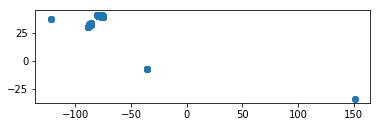

In [112]:
mapping_gdf.plot()

Bad graph -- so let's keep going...

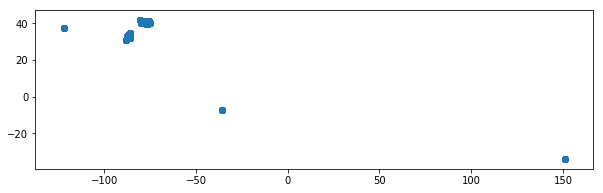

In [113]:
base=mapping_gdf.plot(color='#f0fff0', edgecolor='#202020', figsize=(10,10))
mapping_gdf.plot(ax=base)

Bad graph -- so let's keep going...

In [114]:
import plotly.express as px
fig = px.scatter_mapbox(mapping_gdf, lat="lat", lon="lng", hover_name="building_id",
                        color_discrete_sequence=["red"], zoom=8, height=300)
fig.update_layout(mapbox_style="stamen-toner")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [115]:
plotly.io.write_html(fig, file='grandmastermap.html')

Although these maps are really cool to see all my buildings -- because there are so many plots -- I think it would be more useful to make maps with a more targetted range of points.

See notebook 9 for this analysis
